In this notebook I am checking how many runs and zenith there is in the orange and green dataset and choosing the other dataset runs according to this number

In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import yaml

from gammapy.data import DataStore

import datetime
import matplotlib.dates as mdates

In [2]:
hesseras = ['hess1', 'hess2', 'hess1u']
with open("/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/general_config.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
conf=cfg['conf']
colors = ['darkblue', 'C0', 'C1', 'C2', 'C5']

In [3]:
def get_table(runlist, hessera):
    basedir = f'$FITS_PROD/{hessera}/std_{conf}_fullEnclosure'
    ds = DataStore.from_dir(basedir, f'hdu-index-bg-latest-fov-radec.fits.gz', f'obs-index-bg-latest-fov-radec.fits.gz')
    obs_table = ds.obs_table

    mask = [True if obsid in runlist else False for obsid in obs_table['OBS_ID']]
    obs_table=obs_table[mask]
    return obs_table

full_info = []
for hessera in hesseras:
    name_afterFermi = 'v1'
    if hessera == 'hess1':
        for idx in range(3):
            runlist = np.loadtxt(f'../runlist_{hessera}_{idx}.txt')
            full_info.append(get_table(runlist, hessera))
    else:
        runlist = np.loadtxt(f'../runlist_{hessera}.txt')
        full_info.append(get_table(runlist, hessera))

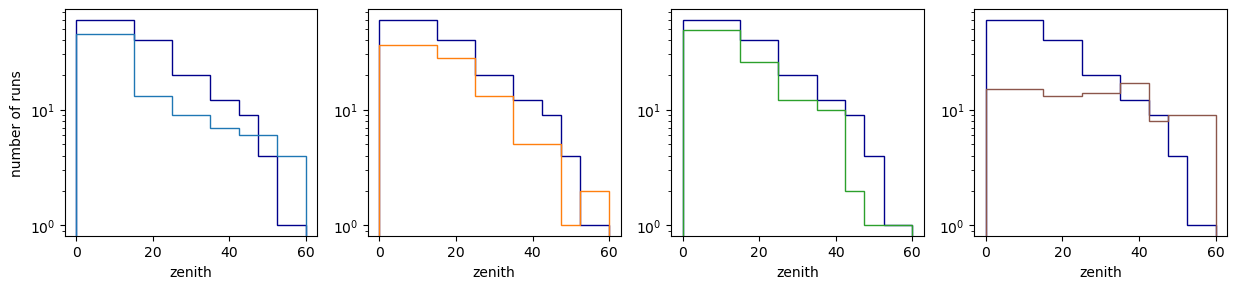

In [4]:
fig, ax = plt.subplots(1,4, figsize=(15, 3), dpi=100)

zen_bins=cfg['zen_bins']
for i, table in enumerate(full_info):
    if i!=0:
        ax[i-1].hist(full_info[0]['ZEN_PNT'], histtype='step', bins = zen_bins, color=colors[0])
        ax[i-1].hist(table['ZEN_PNT'], histtype='step', bins = zen_bins, color=colors[i])
        if i==1:
            ax[i-1].set_ylabel('number of runs')
        ax[i-1].set_xlabel('zenith')
        ax[i-1].set_yscale('log')
plt.show()

# what is the minimum of runs per zenith bin in each dataset

I want to do a selection within the dataset of runs with same configuration

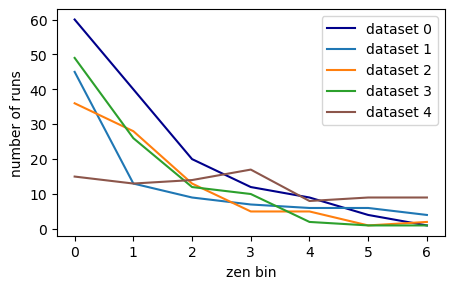

In [5]:
fig, ax = plt.subplots(1,1, figsize=(5, 3), dpi=100)

zen_distributions = []
zen_bins=cfg['zen_bins']
for idx, table in enumerate(full_info):
    dist = np.histogram(full_info[idx]['ZEN_PNT'], bins=zen_bins)
    zen_distributions.append(dist[0])
    ax.plot(dist[0], color=colors[idx], label=f'dataset {idx}')
ax.set_ylabel('number of runs')
ax.set_xlabel('zen bin')
ax.legend()

zen_distributions = np.asarray(zen_distributions)

In [6]:
min_of_runs=np.min(zen_distributions.T, axis=1)
datasets_idx_min = np.argmin(zen_distributions.T, axis=1)
print(f'min of runs per zenith bin= {min_of_runs}')
print(f'the dataset with min of runs per zenith bin= {datasets_idx_min}')

min of runs per zenith bin= [15 13  9  5  2  1  1]
the dataset with min of runs per zenith bin= [4 1 1 2 3 2 0]


What are these runs? 

In [7]:
min_table = []
for zen_idx in range(len(zen_bins)-1):
    aux = full_info[datasets_idx_min[zen_idx]]
    mask = (aux['ZEN_PNT'] > zen_bins[zen_idx]) & (aux['ZEN_PNT'] < zen_bins[zen_idx+1])
    min_table.append(aux[mask])

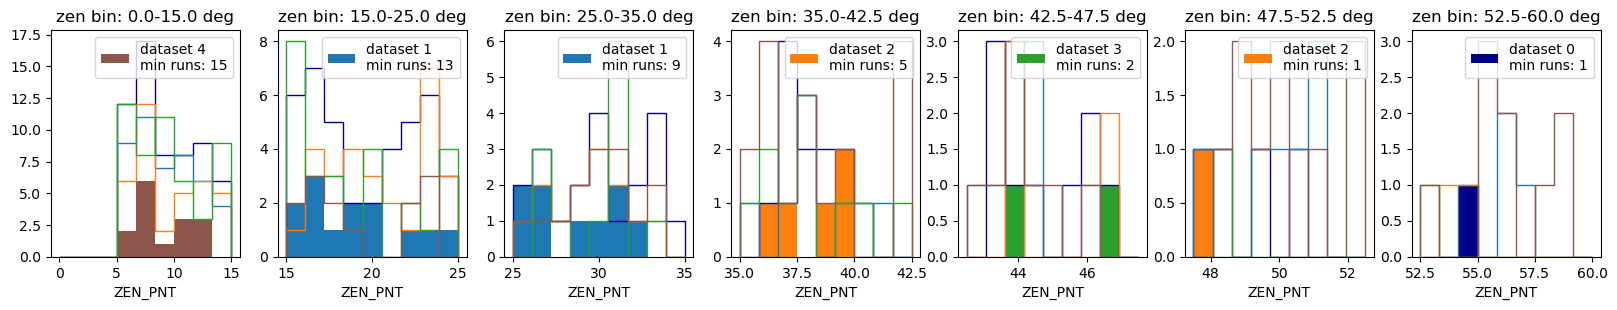

In [8]:
fig, ax = plt.subplots(1,7, figsize=(20, 3), dpi=100)

for zen_idx in range(len(zen_bins)-1):
    for idx, table in enumerate(full_info):
        histtype='step'
        label=None
        if idx == datasets_idx_min[zen_idx]:
            histtype='stepfilled'
            label=f'dataset {idx}\nmin runs: {min_of_runs[zen_idx]}'
        ax[zen_idx].hist(table['ZEN_PNT'], bins=np.linspace(zen_bins[zen_idx], zen_bins[zen_idx+1], 10), color=colors[idx], histtype=histtype, label=label)
    ax[zen_idx].set_xlabel('ZEN_PNT')
    ax[zen_idx].legend()
    ax[zen_idx].set_title(f'zen bin: {zen_bins[zen_idx]}-{zen_bins[zen_idx+1]} deg')

# creating the minimal runlist, based on the zeniths

In [9]:
runlist_min = []
for table in min_table:
    for run in table:
        runlist_min.append([run['OBS_ID'], run['ZEN_PNT']])

In [10]:
print(f'there is a total of {len(runlist_min)} runs')

there is a total of 46 runs


### selecting the runs for each dataset based on the minimal distance of the zenith from runlist_run

In [66]:
runlist_new_datasets = []
runlist_zen_new_datasets = []
for idx, table in enumerate(full_info):
    runlist = []
    zenlist= []
    for runs in runlist_min:
        zen_idx = np.sum(runs[1] > zen_bins)
        mask = (table['ZEN_PNT'] > zen_bins[zen_idx-1]) & (table['ZEN_PNT'] < zen_bins[zen_idx])
        
        argmin_array =np.argsort(abs(table['ZEN_PNT'][mask]-runs[1]))
        used=0
        while table[mask][argmin_array[used]]['OBS_ID'] in runlist:
            used += 1
        runlist.append(table[mask][argmin_array[used]]['OBS_ID'])
        zenlist.append(table[mask][argmin]['ZEN_PNT'])
       
    runlist_new_datasets.append(runlist)
    runlist_zen_new_datasets.append(zenlist)

In [67]:
full_info_new = []
for idx, runlist in enumerate(runlist_new_datasets):
    hessera= 'hess1'
    if idx == 3:
        hessera= 'hess2'
    elif idx == 4:
        hessera= 'hess1u'
        
    basedir = f'$FITS_PROD/{hessera}/std_{conf}_fullEnclosure'
    ds = DataStore.from_dir(basedir, f'hdu-index-bg-latest-fov-radec.fits.gz', f'obs-index-bg-latest-fov-radec.fits.gz')
    obs_table = ds.obs_table

    mask = [True if obsid in np.sort(runlist) else False for obsid in obs_table['OBS_ID']]
    print(np.sum(mask))
    obs_table=obs_table[mask]
    
    full_info_new.append(obs_table)

46
46
46
46
46


In [72]:
N_bin_met = 8
time_label=['2008-2010', '2010-2012', '2012-2014', '2014-2016', '2016-2018', '2018-2020', '2020-2022']
day = '27'
month = '10'

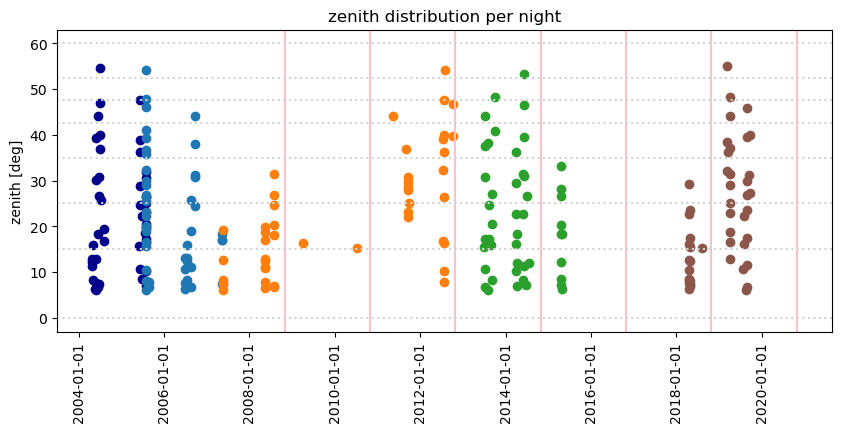

In [71]:
fig, ax = plt.subplots(1,1, figsize=(10, 4), dpi=100)

for i, table in enumerate(full_info_new):
    list_date = []
    for j in range(len(table)):
        list_date.append([table['DATE-OBS'][j], table['ZEN_PNT'][j]])
    list_date = np.asarray(list_date)
    
    x_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in list_date[:, 0]]
        
    formatter = mdates.DateFormatter("%Y-%m-%d")    
    ax.xaxis.set_major_formatter(formatter)
    locator = mdates.YearLocator(2)
    ax.xaxis.set_major_locator(locator)

    ax.scatter(x_values, list_date[:, 1].astype(float), label=f'dataset {i}', color=colors[i])
    
for n_bin_met in range(N_bin_met-1):
    if n_bin_met == N_bin_met-1:
        edge=datetime.datetime.strptime(f'{time_label[n_bin_met][5:]}-{month}-{day}',"%Y-%m-%d").date()
    else:
        edge=datetime.datetime.strptime(f'{time_label[n_bin_met][:4]}-{month}-{day}',"%Y-%m-%d").date()
    label = None
    if n_bin_met == 0:
        label='fermi time bin edges'
    ax.axvline(edge, color='pink', label=label)
    
zen_bins=cfg['zen_bins']
for zen in zen_bins:
    ax.axhline(zen, ls=':', color='lightgray')
plt.xticks(rotation=90)
plt.ylabel('zenith [deg]')
plt.title('zenith distribution per night')
#plt.legend()
plt.show()

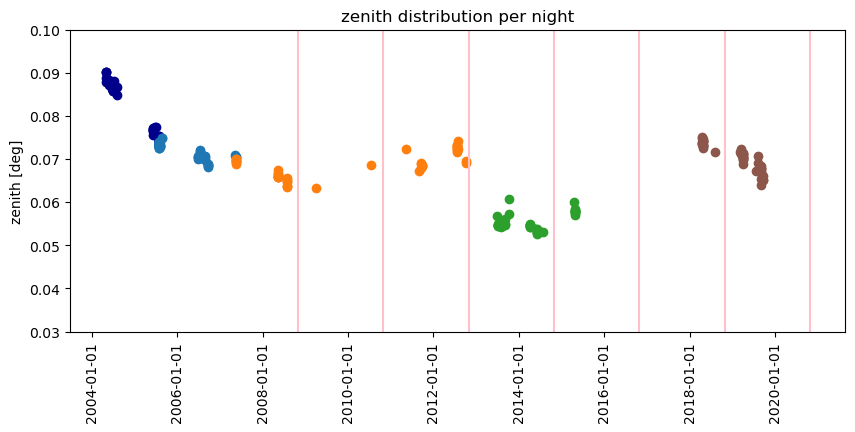

In [76]:
fig, ax = plt.subplots(1,1, figsize=(10, 4), dpi=100)
N_bin_met = 8
time_label=['2008-2010', '2010-2012', '2012-2014', '2014-2016', '2016-2018', '2018-2020', '2020-2022']
day = '27'
month = '10'

for i, table in enumerate(full_info_new):
    list_date = []
    for j in range(len(table)):
        list_date.append([table['DATE-OBS'][j], table['MUONEFF'][j]])
    list_date = np.asarray(list_date)
    
    x_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in list_date[:, 0]]
        
    formatter = mdates.DateFormatter("%Y-%m-%d")    
    ax.xaxis.set_major_formatter(formatter)
    locator = mdates.YearLocator(2)
    ax.xaxis.set_major_locator(locator)

    ax.scatter(x_values, list_date[:, 1].astype(float), label=f'dataset {i}', color=colors[i])
    
for n_bin_met in range(N_bin_met-1):
    if n_bin_met == N_bin_met-1:
        edge=datetime.datetime.strptime(f'{time_label[n_bin_met][5:]}-{month}-{day}',"%Y-%m-%d").date()
    else:
        edge=datetime.datetime.strptime(f'{time_label[n_bin_met][:4]}-{month}-{day}',"%Y-%m-%d").date()
    label = None
    if n_bin_met == 0:
        label='fermi time bin edges'
    ax.axvline(edge, color='pink', label=label)
    
plt.xticks(rotation=90)
plt.ylabel('zenith [deg]')
plt.ylim(0.03, 0.1)
plt.title('zenith distribution per night')
#plt.legend()
plt.show()

In [78]:
counter = 0
for hessera in hesseras:
    if hessera == 'hess1':
        for idx in range(3):
            np.savetxt(f'runlist_min_{hessera}_{idx}.txt', np.asarray(runlist_new_datasets[counter]))
            counter+=1
    else:
        np.savetxt(f'runlist_min_{hessera}.txt', np.asarray(runlist_new_datasets[counter]))
        counter+=1